In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trainingdatapro/basketball-tracking-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/basketball-tracking-dataset


In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback


In [3]:
# Directory containing the dataset (update with your path)
dataset_dir = '/kaggle/input/basketball-tracking-dataset'

# Data augmentation and preprocessing
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split data into 80% training and 20% validation
)

# Training data generator
train_data = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
val_data = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Print dataset info
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Class indices: {train_data.class_indices}")


Found 143 images belonging to 2 classes.
Found 35 images belonging to 2 classes.
Training samples: 143
Validation samples: 35
Class indices: {'boxes': 0, 'images': 1}


In [4]:
# Define the CNN model
model = Sequential([
    Input(shape=(224, 224, 3)),  # Input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Regularization
    Dense(len(train_data.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Verify dataset
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")

# Calculate steps
steps_per_epoch = max(1, train_data.samples // train_data.batch_size)
validation_steps = max(1, val_data.samples // val_data.batch_size)

# Train the model
try:
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
except AttributeError as e:
    print(f"Error during training: {e}")
    print("Disabling validation for debugging.")
    history = model.fit(
        train_data,
        epochs=10,
        steps_per_epoch=steps_per_epoch
    )


Training samples: 143
Validation samples: 35
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5338 - loss: 1.1672 - val_accuracy: 0.5938 - val_loss: 0.4826
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5312 - loss: 0.6375 - val_accuracy: 0.6667 - val_loss: 0.4627
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7086 - loss: 0.5646Error during training: 'NoneType' object has no attribute 'items'
Disabling validation for debugging.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6287 - loss: 0.5501
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.3621
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6686 - loss: 0.5121
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5938 - loss: 0.6159
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8681 - loss: 0.3394
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.2660
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9521 - loss: 0.1822
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8667 - loss: 0.1733  
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9448 - loss: 0.1629
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0351  


In [6]:
# Save the trained model
model.save('basketball_object_cnn.h5')
print("Model saved successfully.")

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_data, steps=validation_steps)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%, Validation Loss: {val_loss:.4f}")


Model saved successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9688 - loss: 0.0522
Validation Accuracy: 96.88%, Validation Loss: 0.0522


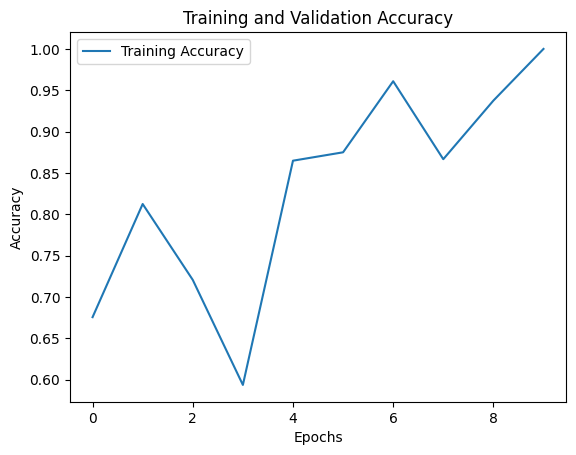

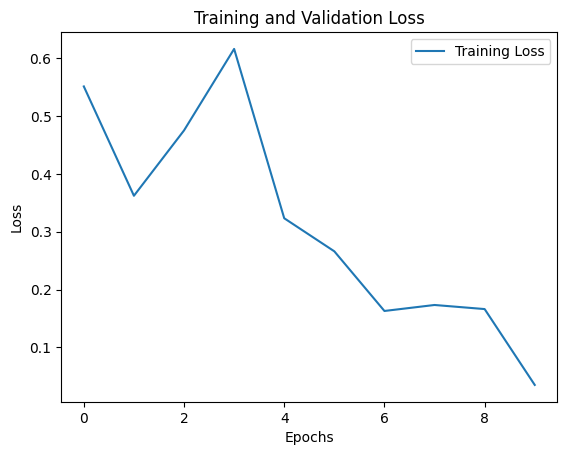

In [7]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Check if 'val_accuracy' exists before plotting
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')

# Check if 'val_loss' exists before plotting
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
